In [40]:
import numpy as np, pandas as pd, tensorflow as tf, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

***
## Análisis exploratorio de datos

In [2]:
data_set = pd.read_csv("recipeData.csv", encoding = "latin-1")
data_set.head(2)

,BeerID,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,...,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount,UserId
0,1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.055,1.013,5.48,17.65,...,1.038,70.0,NaN,Specific Gravity,All Grain,NaN,17.78,corn sugar,4.5 oz,116.0
1,2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumk...,Holiday/Winter Special Spiced Beer,85,20.82,1.083,1.021,8.16,60.65,...,1.070,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,955.0


In [3]:
data_shape = data_set.shape
data_shape

(73861, 23)

In [4]:
col_name = data_set.columns
col_name

Index(['BeerID', 'Name', 'URL', 'Style', 'StyleID', 'Size(L)', 'OG', 'FG',
       'ABV', 'IBU', 'Color', 'BoilSize', 'BoilTime', 'BoilGravity',
       'Efficiency', 'MashThickness', 'SugarScale', 'BrewMethod', 'PitchRate',
       'PrimaryTemp', 'PrimingMethod', 'PrimingAmount', 'UserId'],
      dtype='object')

In [5]:
data_set.isnull().sum()

BeerID               0
Name                 1
URL                  0
Style              596
StyleID              0
Size(L)              0
OG                   0
FG                   0
ABV                  0
IBU                  0
Color                0
BoilSize             0
BoilTime             0
BoilGravity       2990
Efficiency           0
MashThickness    29864
SugarScale           0
BrewMethod           0
PitchRate        39252
PrimaryTemp      22662
PrimingMethod    67095
PrimingAmount    69087
UserId           50490
dtype: int64

***
Se eliminan las siguientes features (no son relevantes o tienen más del 50% de la data perdida)
* BeerID
* Name
* URL
* Style
* PrimingMethod
* PrimingAmount
* UserId

In [6]:
col_name = col_name.drop(["BeerID","Name", "URL", "Style", "PrimingMethod", "PrimingAmount", "UserId"])
col_name

Index(['StyleID', 'Size(L)', 'OG', 'FG', 'ABV', 'IBU', 'Color', 'BoilSize',
       'BoilTime', 'BoilGravity', 'Efficiency', 'MashThickness', 'SugarScale',
       'BrewMethod', 'PitchRate', 'PrimaryTemp'],
      dtype='object')

In [7]:
data_set = data_set[col_name]
data_set.head(2)

,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp
0,45,21.77,1.055,1.013,5.48,17.65,4.83,28.39,75,1.038,70.0,NaN,Specific Gravity,All Grain,NaN,17.78
1,85,20.82,1.083,1.021,8.16,60.65,15.64,24.61,60,1.070,70.0,NaN,Specific Gravity,All Grain,NaN,NaN


In [8]:
data_set.isnull().sum()

StyleID              0
Size(L)              0
OG                   0
FG                   0
ABV                  0
IBU                  0
Color                0
BoilSize             0
BoilTime             0
BoilGravity       2990
Efficiency           0
MashThickness    29864
SugarScale           0
BrewMethod           0
PitchRate        39252
PrimaryTemp      22662
dtype: int64

***
#### Data y
Se hace one hot encoding para las label

In [9]:
data_y = to_categorical(data_set.StyleID)
data_y.shape

(73861, 177)

***
### Datos categóricos

In [10]:
data_set.SugarScale.value_counts()

Specific Gravity    71959
Plato                1902
Name: SugarScale, dtype: int64

In [11]:
data_set.BrewMethod.value_counts()

All Grain       49692
BIAB            12016
extract          8626
Partial Mash     3527
Name: BrewMethod, dtype: int64

#### One Hot Encoding SugarScale

In [12]:
data_set.SugarScale = pd.Categorical(data_set.SugarScale)
data_set.SugarScale = data_set.SugarScale.cat.codes 
data_encoded_SugarScale = to_categorical(data_set.SugarScale)
data_encoded_SugarScale.shape

(73861, 2)

#### One Hot Encoding BrewMethod

In [13]:
data_set.BrewMethod = pd.Categorical(data_set.BrewMethod)
data_set.BrewMethod = data_set.BrewMethod.cat.codes 
data_encoded_BrewMethod = to_categorical(data_set.BrewMethod)
data_encoded_BrewMethod.shape

(73861, 4)

***
#### Data x

In [14]:
col_x = col_name.drop(["BoilGravity","MashThickness", "PitchRate", "PrimaryTemp", "SugarScale", "BrewMethod"])
col_x

Index(['StyleID', 'Size(L)', 'OG', 'FG', 'ABV', 'IBU', 'Color', 'BoilSize',
       'BoilTime', 'Efficiency'],
      dtype='object')

In [15]:
data_x = data_set[col_x]
data_x.shape

(73861, 10)

In [16]:
data_x = pd.concat([data_x, pd.DataFrame(data_encoded_SugarScale, columns = ["SugarScale_SG", "SugarScale_Plato"])], axis=1)
data_x.shape

(73861, 12)

In [17]:
data_x = pd.concat([data_x, pd.DataFrame(data_encoded_BrewMethod, columns = ["BrewMethod_AG", "BrewMethod_B", "BrewMethod_E", "BrewMethod_PM"])], axis=1)
data_x.shape

(73861, 16)

In [18]:
data_x.head()

,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,Efficiency,SugarScale_SG,SugarScale_Plato,BrewMethod_AG,BrewMethod_B,BrewMethod_E,BrewMethod_PM
0,45,21.77,1.055,1.013,5.48,17.65,4.83,28.39,75,70.0,0.0,1.0,1.0,0.0,0.0,0.0
1,85,20.82,1.083,1.021,8.16,60.65,15.64,24.61,60,70.0,0.0,1.0,1.0,0.0,0.0,0.0
2,7,18.93,1.063,1.018,5.91,59.25,8.98,22.71,60,70.0,0.0,1.0,0.0,0.0,0.0,1.0
3,7,22.71,1.061,1.017,5.80,54.48,8.50,26.50,60,70.0,0.0,1.0,1.0,0.0,0.0,0.0
4,20,50.00,1.060,1.010,6.48,17.84,4.57,60.00,90,72.0,0.0,1.0,1.0,0.0,0.0,0.0


#### Split data_test y data_train

In [19]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.2, random_state = 0)

***
### Construcción modelo 1

In [20]:
model_1 = Sequential()
model_1.add(Dense(128, input_shape = (16, ), activation = "relu"))
model_1.add(Dense(64, activation = "relu"))
model_1.add(Dense(32, activation = "relu"))
model_1.add(Dense(177, activation = "softmax"))
model_1.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model_1.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 177)               5841      
Total params: 18,353
Trainable params: 18,353
Non-trainable params: 0
_________________________________________________________________


***
### Prueba No. 1
Se utiliza un batch_size de 128

In [21]:
monitor_val_acc_1 = EarlyStopping(monitor = "val_acc", patience = 3)
modelCheckpoint_1 = ModelCheckpoint("beer_batch_128.hdf5", save_best_only = True)

history_1 = model_1.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.2, callbacks = [monitor_val_acc_1, modelCheckpoint_1])
accuracy_1 = model_1.evaluate(x_test, y_test)[1]
print('Accuracy:', accuracy_1)

Instructions for updating:
Use tf.cast instead.
Train on 47270 samples, validate on 11818 samples
Epoch 1/100
47270/47270 [==============================] - 1s 26us/step - loss: 3.3872 - acc: 0.2775 - val_loss: 2.4590 - val_acc: 0.3774
Epoch 2/100
47270/47270 [==============================] - 1s 19us/step - loss: 2.1217 - acc: 0.4573 - val_loss: 1.8478 - val_acc: 0.5346
Epoch 3/100
47270/47270 [==============================] - 1s 19us/step - loss: 1.6980 - acc: 0.5449 - val_loss: 1.5561 - val_acc: 0.5800
Epoch 4/100
47270/47270 [==============================] - 1s 19us/step - loss: 1.5049 - acc: 0.5820 - val_loss: 1.4488 - val_acc: 0.6037
Epoch 5/100
47270/47270 [==============================] - 1s 19us/step - loss: 1.3882 - acc: 0.6065 - val_loss: 1.3364 - val_acc: 0.6272
Epoch 6/100
47270/47270 [==============================] - 1s 19us/step - loss: 1.3137 - acc: 0.6252 - val_loss: 1.2700 - val_acc: 0.6481
Epoch 7/100
47270/47270 [==============================] - 1s 19us/step - 

#### Gráficas

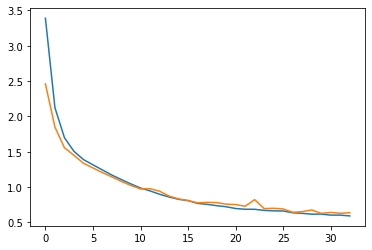

In [23]:
plt.figure()
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])

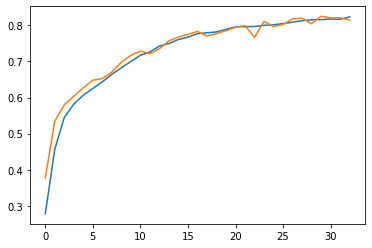

In [25]:
plt.figure()
plt.plot(history_1.history['acc'])
plt.plot(history_1.history['val_acc'])

#### Predicciones

In [44]:
best_model = load_model("beer_batch_128.hdf5")
predicciones = best_model.predict(x_test[:10])
for i, prediccion in enumerate(predicciones):
    print("Predicción: "+str(np.argmax(prediccion)))
    print("Dato Real:  "+str(np.argmax(y_test[i])))
    print("=============================")

Predicción: 10
Dato Real:  10
Predicción: 7
Dato Real:  7
Predicción: 92
Dato Real:  94
Predicción: 7
Dato Real:  7
Predicción: 7
Dato Real:  7
Predicción: 56
Dato Real:  56
Predicción: 7
Dato Real:  7
Predicción: 32
Dato Real:  32
Predicción: 150
Dato Real:  151
Predicción: 80
Dato Real:  81


***
### Prueba No. 2
Sin batch

In [26]:
monitor_val_acc_2 = EarlyStopping(monitor = "val_acc", patience = 3)
modelCheckpoint_2 = ModelCheckpoint("beer_no_batch.hdf5", save_best_only = True)

history_2 = model_1.fit(x_train, y_train, epochs = 100, validation_split = 0.2, callbacks = [monitor_val_acc_2, modelCheckpoint_2])
accuracy_2 = model_1.evaluate(x_test, y_test)[1]
print('Accuracy:', accuracy_2)

Train on 47270 samples, validate on 11818 samples
Epoch 1/100
47270/47270 [==============================] - 2s 42us/step - loss: 0.8474 - acc: 0.7504 - val_loss: 0.8002 - val_acc: 0.7661
Epoch 2/100
47270/47270 [==============================] - 2s 42us/step - loss: 0.7581 - acc: 0.7715 - val_loss: 0.7035 - val_acc: 0.7966
Epoch 3/100
47270/47270 [==============================] - 2s 42us/step - loss: 0.7400 - acc: 0.7771 - val_loss: 0.7747 - val_acc: 0.7792
Epoch 4/100
47270/47270 [==============================] - 2s 42us/step - loss: 0.7135 - acc: 0.7820 - val_loss: 0.6833 - val_acc: 0.8082
Epoch 5/100
47270/47270 [==============================] - 2s 42us/step - loss: 0.7375 - acc: 0.7791 - val_loss: 0.6779 - val_acc: 0.8006
Epoch 6/100
47270/47270 [==============================] - 2s 42us/step - loss: 0.7098 - acc: 0.7874 - val_loss: 0.6927 - val_acc: 0.7984
Epoch 7/100
14773/14773 [==============================] - 0s 14us/step
Accuracy: 0.804643606591675


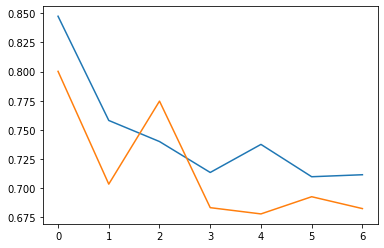

In [27]:
plt.figure()
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])

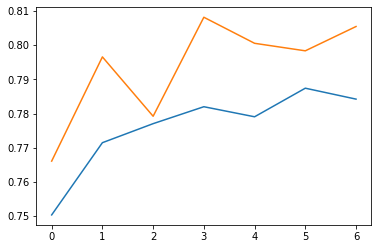

In [29]:
plt.figure()
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])

In [45]:
best_model = load_model("beer_no_batch.hdf5")
predicciones = best_model.predict(x_test[:10])
for i, prediccion in enumerate(predicciones):
    print("Predicción: "+str(np.argmax(prediccion)))
    print("Dato Real:  "+str(np.argmax(y_test[i])))
    print("=============================")

Predicción: 10
Dato Real:  10
Predicción: 7
Dato Real:  7
Predicción: 92
Dato Real:  94
Predicción: 7
Dato Real:  7
Predicción: 7
Dato Real:  7
Predicción: 56
Dato Real:  56
Predicción: 7
Dato Real:  7
Predicción: 32
Dato Real:  32
Predicción: 150
Dato Real:  151
Predicción: 81
Dato Real:  81


***
## Construyendo modelo 2
Con capas BatchNormalization()

In [30]:
norm_model = Sequential()
norm_model.add(Dense(128, input_shape = (16, ), activation = "relu"))
norm_model.add(BatchNormalization())
norm_model.add(Dense(64, activation = "relu"))
norm_model.add(BatchNormalization())
norm_model.add(Dense(32, activation = "relu"))
norm_model.add(BatchNormalization())
norm_model.add(Dense(177, activation = "softmax"))
norm_model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
norm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               2176      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
dense_8 (Dense)              (None, 177)              

#### Prueba No. 3
Sin batch

In [31]:
monitor_val_acc_3 = EarlyStopping(monitor = "val_acc", patience = 3)
modelCheckpoint_3 = ModelCheckpoint("beer_norm_no_batch.hdf5", save_best_only = True)

history_3 = norm_model.fit(x_train, y_train, epochs = 100, validation_split = 0.2, callbacks = [monitor_val_acc_3, modelCheckpoint_3])
accuracy = norm_model.evaluate(x_test, y_test)[1]
print('Accuracy:', accuracy)

Train on 47270 samples, validate on 11818 samples
Epoch 1/100
47270/47270 [==============================] - 4s 93us/step - loss: 2.3637 - acc: 0.4338 - val_loss: 1.5560 - val_acc: 0.5913
Epoch 2/100
47270/47270 [==============================] - 3s 71us/step - loss: 1.4440 - acc: 0.5908 - val_loss: 1.3678 - val_acc: 0.5921
Epoch 3/100
47270/47270 [==============================] - 3s 71us/step - loss: 1.2479 - acc: 0.6346 - val_loss: 1.1245 - val_acc: 0.6779
Epoch 4/100
47270/47270 [==============================] - 3s 72us/step - loss: 1.1643 - acc: 0.6517 - val_loss: 1.0299 - val_acc: 0.7040
Epoch 5/100
47270/47270 [==============================] - 3s 73us/step - loss: 1.1008 - acc: 0.6682 - val_loss: 0.9436 - val_acc: 0.7312
Epoch 6/100
47270/47270 [==============================] - 3s 72us/step - loss: 1.0526 - acc: 0.6803 - val_loss: 0.9324 - val_acc: 0.7351
Epoch 7/100
47270/47270 [==============================] - 3s 72us/step - loss: 1.0054 - acc: 0.6936 - val_loss: 0.9445 - 

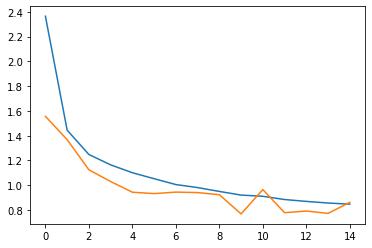

In [34]:
plt.figure()
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])

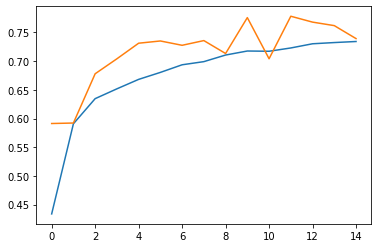

In [36]:
plt.figure()
plt.plot(history_3.history['acc'])
plt.plot(history_3.history['val_acc'])

In [46]:
best_model = load_model("beer_norm_no_batch.hdf5")
predicciones = best_model.predict(x_test[:10])
for i, prediccion in enumerate(predicciones):
    print("Predicción: "+str(np.argmax(prediccion)))
    print("Dato Real:  "+str(np.argmax(y_test[i])))
    print("=============================")

Predicción: 10
Dato Real:  10
Predicción: 7
Dato Real:  7
Predicción: 92
Dato Real:  94
Predicción: 7
Dato Real:  7
Predicción: 7
Dato Real:  7
Predicción: 56
Dato Real:  56
Predicción: 7
Dato Real:  7
Predicción: 29
Dato Real:  32
Predicción: 150
Dato Real:  151
Predicción: 81
Dato Real:  81


#### Prueba No. 4

In [33]:
monitor_val_acc_4 = EarlyStopping(monitor = "val_acc", patience = 3)
modelCheckpoint_4 = ModelCheckpoint("beer_norm_batch_128.hdf5", save_best_only = True)

history_4 = norm_model.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_split = 0.2, callbacks = [monitor_val_acc_4, modelCheckpoint_4])
accuracy = norm_model.evaluate(x_test, y_test)[1]
print('Accuracy:', accuracy)

Train on 47270 samples, validate on 11818 samples
Epoch 1/100
47270/47270 [==============================] - 1s 31us/step - loss: 0.6129 - acc: 0.8116 - val_loss: 0.5916 - val_acc: 0.8275
Epoch 2/100
47270/47270 [==============================] - 1s 29us/step - loss: 0.5833 - acc: 0.8200 - val_loss: 0.5779 - val_acc: 0.8359
Epoch 3/100
47270/47270 [==============================] - 1s 29us/step - loss: 0.5743 - acc: 0.8215 - val_loss: 0.5633 - val_acc: 0.8396
Epoch 4/100
47270/47270 [==============================] - 1s 29us/step - loss: 0.5689 - acc: 0.8212 - val_loss: 0.5830 - val_acc: 0.8200
Epoch 5/100
47270/47270 [==============================] - 1s 29us/step - loss: 0.5577 - acc: 0.8250 - val_loss: 0.5511 - val_acc: 0.8352
Epoch 6/100
47270/47270 [==============================] - 1s 29us/step - loss: 0.5544 - acc: 0.8254 - val_loss: 0.5466 - val_acc: 0.8433
Epoch 7/100
47270/47270 [==============================] - 1s 29us/step - loss: 0.5497 - acc: 0.8257 - val_loss: 0.5694 - 

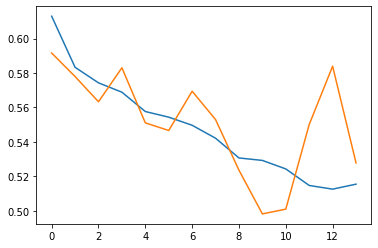

In [37]:
plt.figure()
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])

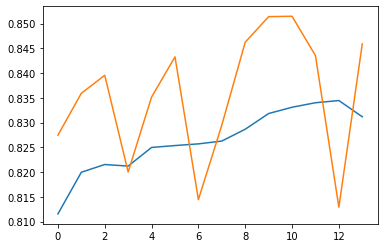

In [38]:
plt.figure()
plt.plot(history_4.history['acc'])
plt.plot(history_4.history['val_acc'])

In [47]:
best_model = load_model("beer_norm_batch_128.hdf5")
predicciones = best_model.predict(x_test[:10])
for i, prediccion in enumerate(predicciones):
    print("Predicción: "+str(np.argmax(prediccion)))
    print("Dato Real:  "+str(np.argmax(y_test[i])))
    print("=============================")

Predicción: 10
Dato Real:  10
Predicción: 7
Dato Real:  7
Predicción: 92
Dato Real:  94
Predicción: 7
Dato Real:  7
Predicción: 7
Dato Real:  7
Predicción: 56
Dato Real:  56
Predicción: 7
Dato Real:  7
Predicción: 32
Dato Real:  32
Predicción: 150
Dato Real:  151
Predicción: 81
Dato Real:  81


***
### Probando con otros hyperparametros

In [31]:
def create_model(learning_rate = 0.01, activation = "relu"):
    model = Sequential()
    model.add(Dense(128, input_shape = (16, ), activation = activation))
    model.add(Dense(64, activation = activation))
    model.add(Dense(32, activation = activation))
    model.add(Dense(177, activation = "softmax"))
    opt = Adam(lr=learning_rate)
    model.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["accuracy"])
    return model

In [32]:
model = KerasClassifier(build_fn = create_model)

In [34]:
params = {"activation":["relu","tanh","sigmoid"], "batch_size":[16,32,128], "epochs":[25, 50, 100], "learning_rate":[0.1, 0.01, 0.001, 0.0001, 0.005]}

In [35]:
random_search = RandomizedSearchCV(model, param_distributions=params, cv=3)
random_search_results = random_search.fit(x_test, y_test)

Epoch 1/100
9848/9848 [==============================] - 2s 248us/step - loss: 2.9988 - acc: 0.2795
Epoch 2/100
9848/9848 [==============================] - 1s 62us/step - loss: 2.6083 - acc: 0.3221
Epoch 3/100
9848/9848 [==============================] - 1s 62us/step - loss: 2.5642 - acc: 0.3286
Epoch 4/100
9848/9848 [==============================] - 1s 61us/step - loss: 2.4874 - acc: 0.3401
Epoch 5/100
9848/9848 [==============================] - 1s 61us/step - loss: 2.5499 - acc: 0.3398
Epoch 6/100
9848/9848 [==============================] - 1s 61us/step - loss: 2.4488 - acc: 0.3639
Epoch 7/100
9848/9848 [==============================] - 1s 62us/step - loss: 2.4409 - acc: 0.3743
Epoch 8/100
9848/9848 [==============================] - 1s 61us/step - loss: 2.4048 - acc: 0.3823
Epoch 9/100
9848/9848 [==============================] - 1s 61us/step - loss: 2.4704 - acc: 0.3661
Epoch 10/100
9848/9848 [==============================] - 1s 61us/step - loss: 2.3959 - acc: 0.3890
Epoch 11

9848/9848 [==============================] - ETA: 0s - loss: 3.0743 - acc: 0.224 - 1s 60us/step - loss: 3.0706 - acc: 0.2219
Epoch 84/100
9848/9848 [==============================] - 1s 63us/step - loss: 3.0970 - acc: 0.2133
Epoch 85/100
9848/9848 [==============================] - 1s 60us/step - loss: 3.1443 - acc: 0.2194
Epoch 86/100
9848/9848 [==============================] - 1s 61us/step - loss: 3.2297 - acc: 0.2324
Epoch 87/100
9848/9848 [==============================] - 1s 61us/step - loss: 3.0688 - acc: 0.2145
Epoch 88/100
9848/9848 [==============================] - 1s 59us/step - loss: 3.1031 - acc: 0.2234
Epoch 89/100
9848/9848 [==============================] - 1s 58us/step - loss: 3.0331 - acc: 0.2185
Epoch 90/100
9848/9848 [==============================] - 1s 59us/step - loss: 3.1767 - acc: 0.2172
Epoch 91/100
9848/9848 [==============================] - 1s 59us/step - loss: 3.2685 - acc: 0.2379
Epoch 92/100
9848/9848 [==============================] - 1s 60us/step - lo

9849/9849 [==============================] - 1s 65us/step - loss: 2.9309 - acc: 0.2774
Epoch 46/100
9849/9849 [==============================] - 1s 65us/step - loss: 2.9019 - acc: 0.2975
Epoch 47/100
9849/9849 [==============================] - 1s 64us/step - loss: 2.9658 - acc: 0.2911
Epoch 48/100
9849/9849 [==============================] - 1s 64us/step - loss: 2.9409 - acc: 0.2901
Epoch 49/100
9849/9849 [==============================] - 1s 64us/step - loss: 3.0113 - acc: 0.2584
Epoch 50/100
9849/9849 [==============================] - 1s 64us/step - loss: 2.9182 - acc: 0.2548
Epoch 51/100
9849/9849 [==============================] - 1s 67us/step - loss: 2.9280 - acc: 0.2772
Epoch 52/100
9849/9849 [==============================] - 1s 66us/step - loss: 2.9835 - acc: 0.2576
Epoch 53/100
9849/9849 [==============================] - 1s 64us/step - loss: 3.0878 - acc: 0.2407
Epoch 54/100
9849/9849 [==============================] - 1s 62us/step - loss: 3.0976 - acc: 0.2319
Epoch 55/100


Epoch 1/25
9849/9849 [==============================] - 2s 242us/step - loss: 4.6944 - acc: 0.1745
Epoch 2/25
9849/9849 [==============================] - 0s 35us/step - loss: 3.4267 - acc: 0.2496
Epoch 3/25
9849/9849 [==============================] - 0s 36us/step - loss: 2.9788 - acc: 0.3102
Epoch 4/25
9849/9849 [==============================] - 0s 36us/step - loss: 2.5651 - acc: 0.3840
Epoch 5/25
9849/9849 [==============================] - 0s 36us/step - loss: 2.2720 - acc: 0.4351
Epoch 6/25
9849/9849 [==============================] - 0s 35us/step - loss: 2.0514 - acc: 0.4719
Epoch 7/25
9849/9849 [==============================] - 0s 34us/step - loss: 1.8881 - acc: 0.5060
Epoch 8/25
9849/9849 [==============================] - 0s 35us/step - loss: 1.7814 - acc: 0.5281
Epoch 9/25
9849/9849 [==============================] - 0s 34us/step - loss: 1.6849 - acc: 0.5459
Epoch 10/25
9849/9849 [==============================] - 0s 33us/step - loss: 1.6059 - acc: 0.5588
Epoch 11/25
9849/9

9848/9848 [==============================] - 0s 36us/step - loss: 1.1632 - acc: 0.6699
Epoch 38/50
9848/9848 [==============================] - 0s 35us/step - loss: 1.1367 - acc: 0.6758
Epoch 39/50
9848/9848 [==============================] - 0s 35us/step - loss: 1.1233 - acc: 0.6810
Epoch 40/50
9848/9848 [==============================] - 0s 37us/step - loss: 1.1074 - acc: 0.6865
Epoch 41/50
9848/9848 [==============================] - 0s 36us/step - loss: 1.0966 - acc: 0.6904
Epoch 42/50
9848/9848 [==============================] - 0s 36us/step - loss: 1.0879 - acc: 0.6911
Epoch 43/50
9848/9848 [==============================] - 0s 38us/step - loss: 1.0905 - acc: 0.6846
Epoch 44/50
9848/9848 [==============================] - 0s 41us/step - loss: 1.0704 - acc: 0.6942
Epoch 45/50
9848/9848 [==============================] - 0s 38us/step - loss: 1.0612 - acc: 0.6979
Epoch 46/50
9848/9848 [==============================] - 0s 36us/step - loss: 1.0551 - acc: 0.6970
Epoch 47/50
9848/9848 

4925/4925 [==============================] - 1s 214us/step
Epoch 1/50
9849/9849 [==============================] - 3s 296us/step - loss: 5.0835 - acc: 0.0095
Epoch 2/50
9849/9849 [==============================] - 0s 37us/step - loss: 4.9326 - acc: 0.1467
Epoch 3/50
9849/9849 [==============================] - 0s 38us/step - loss: 4.7821 - acc: 0.1794
Epoch 4/50
9849/9849 [==============================] - 0s 37us/step - loss: 4.6330 - acc: 0.1839
Epoch 5/50
9849/9849 [==============================] - 0s 39us/step - loss: 4.4947 - acc: 0.1070
Epoch 6/50
9849/9849 [==============================] - 0s 38us/step - loss: 4.3764 - acc: 0.1091
Epoch 7/50
9849/9849 [==============================] - 0s 38us/step - loss: 4.2835 - acc: 0.1706
Epoch 8/50
9849/9849 [==============================] - 0s 38us/step - loss: 4.2156 - acc: 0.1628
Epoch 9/50
9849/9849 [==============================] - 0s 37us/step - loss: 4.1671 - acc: 0.1624
Epoch 10/50
9849/9849 [==============================] - 0

9848/9848 [==============================] - 0s 38us/step - loss: 1.0579 - acc: 0.6748
Epoch 63/100
9848/9848 [==============================] - 0s 39us/step - loss: 1.0991 - acc: 0.6551
Epoch 64/100
9848/9848 [==============================] - 0s 40us/step - loss: 1.0610 - acc: 0.6697
Epoch 65/100
9848/9848 [==============================] - 0s 38us/step - loss: 1.0419 - acc: 0.6799
Epoch 66/100
9848/9848 [==============================] - 0s 39us/step - loss: 1.0242 - acc: 0.6797
Epoch 67/100
9848/9848 [==============================] - 0s 41us/step - loss: 1.0553 - acc: 0.6705
Epoch 68/100
9848/9848 [==============================] - 0s 39us/step - loss: 1.0356 - acc: 0.6775
Epoch 69/100
9848/9848 [==============================] - 0s 40us/step - loss: 1.0469 - acc: 0.6770
Epoch 70/100
9848/9848 [==============================] - 0s 40us/step - loss: 0.9972 - acc: 0.6904
Epoch 71/100
9848/9848 [==============================] - 0s 39us/step - loss: 1.0557 - acc: 0.6708: 0s - loss: 1

9849/9849 [==============================] - 0s 39us/step - loss: 1.3681 - acc: 0.5933
Epoch 24/100
9849/9849 [==============================] - 0s 40us/step - loss: 1.3446 - acc: 0.6005
Epoch 25/100
9849/9849 [==============================] - 0s 39us/step - loss: 1.2957 - acc: 0.6058: 0s - loss: 1.3057 - acc: 
Epoch 26/100
9849/9849 [==============================] - 0s 40us/step - loss: 1.2857 - acc: 0.6134
Epoch 27/100
9849/9849 [==============================] - 0s 41us/step - loss: 1.3313 - acc: 0.6007
Epoch 28/100
9849/9849 [==============================] - 0s 39us/step - loss: 1.2615 - acc: 0.6180
Epoch 29/100
9849/9849 [==============================] - 0s 40us/step - loss: 1.3213 - acc: 0.6034
Epoch 30/100
9849/9849 [==============================] - 0s 39us/step - loss: 1.2972 - acc: 0.6094
Epoch 31/100
9849/9849 [==============================] - 0s 39us/step - loss: 1.2798 - acc: 0.6112
Epoch 32/100
9849/9849 [==============================] - 0s 40us/step - loss: 1.2630 

9849/9849 [==============================] - 1s 75us/step - loss: 1.1466 - acc: 0.6792
Epoch 35/50
9849/9849 [==============================] - 1s 75us/step - loss: 1.1390 - acc: 0.6793
Epoch 36/50
9849/9849 [==============================] - 1s 73us/step - loss: 1.1197 - acc: 0.6868
Epoch 37/50
9849/9849 [==============================] - 1s 74us/step - loss: 1.1040 - acc: 0.6915
Epoch 38/50
9849/9849 [==============================] - 1s 72us/step - loss: 1.0897 - acc: 0.6895
Epoch 39/50
9849/9849 [==============================] - 1s 74us/step - loss: 1.0771 - acc: 0.6920
Epoch 40/50
9849/9849 [==============================] - 1s 77us/step - loss: 1.0640 - acc: 0.6983
Epoch 41/50
9849/9849 [==============================] - 1s 73us/step - loss: 1.0528 - acc: 0.6967
Epoch 42/50
9849/9849 [==============================] - 1s 73us/step - loss: 1.0388 - acc: 0.7064
Epoch 43/50
9849/9849 [==============================] - 1s 73us/step - loss: 1.0356 - acc: 0.7023
Epoch 44/50
9849/9849 

9848/9848 [==============================] - 1s 137us/step - loss: 1.9464 - acc: 0.4613
Epoch 96/100
9848/9848 [==============================] - 1s 138us/step - loss: 2.0923 - acc: 0.4272
Epoch 97/100
9848/9848 [==============================] - 1s 139us/step - loss: 2.0476 - acc: 0.4316
Epoch 98/100
9848/9848 [==============================] - 2s 156us/step - loss: 2.0864 - acc: 0.4007
Epoch 99/100
9848/9848 [==============================] - 2s 155us/step - loss: 2.0276 - acc: 0.4383
Epoch 100/100
4925/4925 [==============================] - 2s 324us/step
Epoch 1/100
9849/9849 [==============================] - 4s 449us/step - loss: 2.9650 - acc: 0.2896
Epoch 2/100
9849/9849 [==============================] - 1s 139us/step - loss: 2.3639 - acc: 0.3872
Epoch 3/100
9849/9849 [==============================] - 1s 140us/step - loss: 2.2291 - acc: 0.4145
Epoch 4/100
9849/9849 [==============================] - 2s 156us/step - loss: 2.1913 - acc: 0.4213
Epoch 5/100
9849/9849 [============

9849/9849 [==============================] - 1s 138us/step - loss: 1.9633 - acc: 0.4727
Epoch 56/100
9849/9849 [==============================] - 1s 137us/step - loss: 2.0014 - acc: 0.4423
Epoch 57/100
9849/9849 [==============================] - 1s 137us/step - loss: 1.9884 - acc: 0.4400
Epoch 58/100
9849/9849 [==============================] - 1s 139us/step - loss: 2.0273 - acc: 0.4286
Epoch 59/100
9849/9849 [==============================] - 1s 137us/step - loss: 2.0287 - acc: 0.4417
Epoch 60/100
9849/9849 [==============================] - 1s 135us/step - loss: 1.9383 - acc: 0.4624
Epoch 61/100
9849/9849 [==============================] - 1s 138us/step - loss: 1.9561 - acc: 0.4600
Epoch 62/100
9849/9849 [==============================] - 1s 138us/step - loss: 1.9363 - acc: 0.4593
Epoch 63/100
9849/9849 [==============================] - 1s 137us/step - loss: 1.9398 - acc: 0.4670
Epoch 64/100
9849/9849 [==============================] - 1s 138us/step - loss: 2.0282 - acc: 0.4325
Epo

9848/9848 [==============================] - 1s 144us/step - loss: 4.2519 - acc: 0.1566
Epoch 41/100
9848/9848 [==============================] - 1s 142us/step - loss: 4.2551 - acc: 0.1547
Epoch 42/100
9848/9848 [==============================] - 1s 145us/step - loss: 4.2558 - acc: 0.1538
Epoch 43/100
9848/9848 [==============================] - 2s 163us/step - loss: 4.2475 - acc: 0.1518
Epoch 44/100
9848/9848 [==============================] - 2s 157us/step - loss: 4.2428 - acc: 0.1583
Epoch 45/100
9848/9848 [==============================] - 2s 163us/step - loss: 4.2481 - acc: 0.1554
Epoch 46/100
9848/9848 [==============================] - 2s 158us/step - loss: 4.2535 - acc: 0.1533
Epoch 47/100
9848/9848 [==============================] - 2s 161us/step - loss: 4.2454 - acc: 0.1594
Epoch 48/100
9848/9848 [==============================] - 2s 160us/step - loss: 4.2417 - acc: 0.1569
Epoch 49/100
9848/9848 [==============================] - 2s 160us/step - loss: 4.2514 - acc: 0.1570
Epo

4924/4924 [==============================] - 2s 361us/step
Epoch 1/100
9849/9849 [==============================] - 5s 498us/step - loss: 4.2164 - acc: 0.1579
Epoch 2/100
9849/9849 [==============================] - 2s 152us/step - loss: 4.1956 - acc: 0.1584
Epoch 3/100
9849/9849 [==============================] - 1s 148us/step - loss: 4.1950 - acc: 0.1576
Epoch 4/100
9849/9849 [==============================] - 1s 149us/step - loss: 4.1942 - acc: 0.1564
Epoch 5/100
9849/9849 [==============================] - 1s 149us/step - loss: 4.1995 - acc: 0.1603
Epoch 6/100
9849/9849 [==============================] - 1s 150us/step - loss: 4.2016 - acc: 0.1584
Epoch 7/100
9849/9849 [==============================] - 1s 148us/step - loss: 4.1960 - acc: 0.1569
Epoch 8/100
9849/9849 [==============================] - 1s 148us/step - loss: 4.1918 - acc: 0.1609
Epoch 9/100
9849/9849 [==============================] - 1s 148us/step - loss: 4.1948 - acc: 0.1580
Epoch 10/100
9849/9849 [=================

In [36]:
random_search_results.best_score_

0.7019562715240736

In [37]:
random_search_results.best_params_

{'learning_rate': 0.001,
 'epochs': 50,
 'batch_size': 32,
 'activation': 'sigmoid'}

***
# Conclusiones

* Se utilizó una MLP para hacer la clasificación de tipos de cerveza según la receta propuesta por usuarios de un sitio web. 
* El mejor modelo encontrado fue beer_norm_batch_128.hdf5 en el que se utilizaron capas de BatchNormalization para el modelo y un batch_size de 128 logrando un 84% de accuracy en el modelo.
* Las curvas de aprendizaje del modelo pueden tener variaciones (algunas veces sube o baja la pérdida).